<a href="https://colab.research.google.com/github/meriemdouider1/2/blob/main/12345.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Installation des packages :

In [1]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical# convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
%matplotlib inline
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model

Tout d'abord, récupérons l'ensemble de données Glaucoma Positive  contre Glaucoma négative  en utilisant kaggle 

In [2]:
! pip install -q kaggle

In [3]:
from google.colab import files

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"meryemdouider","key":"e6d4d9e76ba23b2dc984f747113db5ce"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "sshikamaru/glaucoma-detection"

kaggle.json
100% 188M/188M [00:02<00:00, 130MB/s]



In [6]:
!unzip glaucoma-detection.zip

Archive:  glaucoma-detection.zip
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/001.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/002.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/003.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/004.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/005.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/006.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/007.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/008.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/009.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glaucoma_Negative/010.jpg  
  inflating: Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train/Glauc


Préparation des données entraînement /test / validation :

In [7]:
DATAGlua_Train = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'
DATAGlua_Test = '/content/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

notre jeu deux de données est divisé en deux partie :

*   des données avec un Gluacoma_positive
*   des données avec un Gluacoma_négative





In [8]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATAGlua_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['Glaucoma_Positive', 'Glaucoma_Negative']



Division l'ensemble de données d'entraînement en x_train_data et y_train_data : (x_train_data : 'les images' , y_train_data : 'label / catégorie ')

In [9]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
def creation_train_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Train, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
creation_train_data()

In [10]:
x_test_data = []
y_test_data = []
IMG_SIZE=224
def creation_test_data():
    for category in CATEGORIES:
      path = os.path.join(DATAGlua_Test, category)
      class_num = CATEGORIES.index(category)
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
creation_test_data ()

In [11]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.05, random_state=1)

In [12]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [13]:
X_Train.shape

(494, 224, 224, 3)

la taille du data test :

In [14]:
len(x_test_data)

130

la taille du data Train/Val

In [15]:
len(X_Train)

494

In [16]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

# **Transfer learning**


# Création du modèle:

# **VGG16 Model**

VGG16 est un modèle de réseau de neurones convolutif proposé par K. Simonyan et A. Zisserman de l'Université d'Oxford dans le document «Very Deep Convolutional Networks for Large-Scale Image Recognition». Le modèle atteint une précision de test de 92,7% dans le top 5 dans ImageNet, qui est un ensemble de données de plus de 14 millions d'images appartenant à 1000 classes. C'était l'un des modèles célèbres soumis à l'ILSVRC-2014. Il apporte une amélioration par rapport à AlexNet en remplaçant les grands filtres de la taille d'un noyau (11 et 5 dans la première et la deuxième couche convolutive, respectivement) par plusieurs filtres 3 × 3 de la taille d'un noyau l'un après l'autre. 

In [17]:
IMG_SHAPE = (224, 224,3)


In [18]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

importer le modèle pré-entraîne VGG 16 :

In [19]:
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


affichage les layer du modèle VGG 16 et Figer le modèle pré-entraine en utilisant la commande layer.trainable = False 

In [20]:
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [22]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
base_model.trainable = False

la sortie du modèle pré-entraîne :

In [24]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

Création d'un nouveau modèle qui va se baser sur les résultas du modèle pré-entraîne :

nous utilisons plusieurs layer : Global MaxPooling2d / dense / Dropout ,
et comme un optimizer nous avons testé plusieurs optimizer  (sgd /adam ) mais se dernier qui a donnée le meilleur résultat

In [25]:
x = layers.GlobalMaxPooling2D()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='softmax')(x)

model = Model(base_model.input, x)
#optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer ,
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

une étape importante avant d'entrainer le modèle est la normalisation pour mettre à l'échelle les valeurs d'entrée (initialement dans la plage [0, 255]) à la plage [0, 1]. cette normalisation est effectuée en utilisant la fonction ImageDataGenerator .
catte fonction va nous permis de normaliser les données d'entrée test et validation.
cette fonction est utilisable aussi pour l'augmentation des données .






Augmentation et normalisation du données test :

In [35]:
train_datagen = ImageDataGenerator(
    validation_split=0.2, 
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.02,
)
train_iterator= train_datagen.flow(
    x=X_Train,
    y=Y_Train,
    batch_size=32,
    subset='training'
)

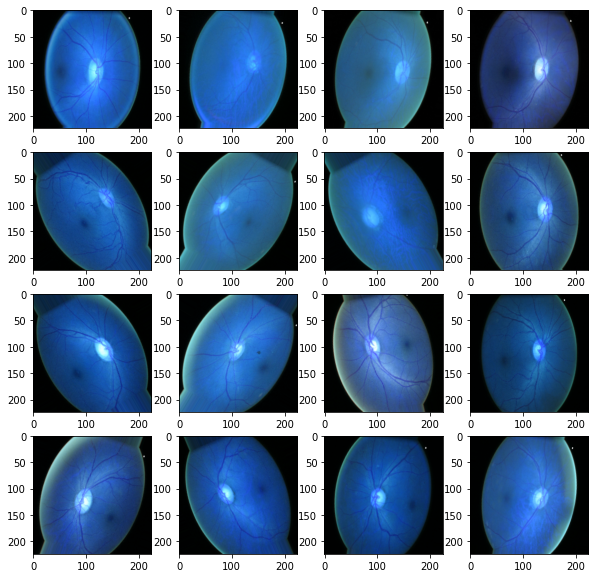

In [36]:
reshaped_train_x = X_Train.reshape((494, 224, 224, 3))
plt.gcf().set_size_inches(10, 10)
for x_batch, y_batch in train_iterator:
    for i in range(0, 16):
        plt.subplot(4, 4, i+1)
        plt.imshow(x_batch[i])
    break

Entraînement du modèle avec des layers du modèle pré-entrâine ( en mode freeze)

In [37]:
X_Val=X_Val/255

In [38]:
X_Val

array([[[[0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         ...,
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05]],

        [[0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         ...,
         [0.00000000e+00, 3.07574010e-05, 3.07574010e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05]],

        [[1.53787005e-05, 1.53787005e-05, 1.53787005e-05],
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [1.53787005e-05, 4.61361015e-05, 4.61361015e-05],
         ...,
         [0.00000000e+00, 1.53787005e-05, 1.53787005e-05],
         [

In [39]:
model.fit_generator(
    generator=train_iterator,
    validation_data=(X_Val, Y_Val),
    epochs=10, 
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
 8/13 [=================>............] - ETA: 1s - loss: 0.5491 - accuracy: 0.7458

KeyboardInterrupt: ignored

In [ ]:
train_model = model.fit(X_Train, Y_Train, batch_size=32, epochs=15,
                    validation_data=(X_Val, Y_Val))

Epoch 1/15
16/16 [==============================] - 3s 138ms/step - loss: 9.7705 - accuracy: 0.6607 - val_loss: 1.7458 - val_accuracy: 0.8077
Epoch 2/15
16/16 [==============================] - 2s 127ms/step - loss: 1.4418 - accuracy: 0.7632 - val_loss: 4.2994 - val_accuracy: 0.3846
Epoch 3/15
16/16 [==============================] - 2s 128ms/step - loss: 2.0583 - accuracy: 0.7065 - val_loss: 1.2015 - val_accuracy: 0.7308
Epoch 4/15
16/16 [==============================] - 2s 129ms/step - loss: 0.6752 - accuracy: 0.8112 - val_loss: 1.2405 - val_accuracy: 0.8462
Epoch 5/15
16/16 [==============================] - 2s 129ms/step - loss: 0.7733 - accuracy: 0.7850 - val_loss: 1.3588 - val_accuracy: 0.8462
Epoch 6/15
16/16 [==============================] - 2s 128ms/step - loss: 0.6098 - accuracy: 0.8310 - val_loss: 3.1444 - val_accuracy: 0.3462
Epoch 7/15
16/16 [==============================] - 2s 129ms/step - loss: 0.4886 - accuracy: 0.8369 - val_loss: 1.0757 - val_accuracy: 0.6923
Epoch 

# **fine-tuning**

dégelons maintenant le modèle de base et formons l'ensemble du modèle de bout en bout avec un faible taux d'apprentissage.

Il est important de noter que bien que le modèle de base devienne entraînable, il fonctionne toujours en mode inférence puisque nous avons passé training = False lors de son appel lorsque nous avons construit le modèle. 

In [ ]:
for layer in model.layers:
    print(layer.name)
    layer.trainable = True
#optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
optimizer = tf.keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

input_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_max_pooling2d_5
dense_15
dense_16
dense_17


In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
train_model  = model.fit(X_Train, Y_Train, batch_size=32, epochs=20,
                    validation_data=(X_Val, Y_Val))

Epoch 1/20
16/16 [==============================] - 8s 438ms/step - loss: 0.3208 - acc: 0.9675 - val_loss: 2.5303 - val_acc: 0.1923
Epoch 2/20
16/16 [==============================] - 7s 415ms/step - loss: 1.2593 - acc: 0.5961 - val_loss: 0.5309 - val_acc: 0.8077
Epoch 3/20
16/16 [==============================] - 7s 409ms/step - loss: 0.5101 - acc: 0.7493 - val_loss: 0.4274 - val_acc: 0.8462
Epoch 4/20
16/16 [==============================] - 6s 406ms/step - loss: 0.4827 - acc: 0.7821 - val_loss: 0.4499 - val_acc: 0.8077
Epoch 5/20
16/16 [==============================] - 6s 405ms/step - loss: 0.4494 - acc: 0.7964 - val_loss: 0.4286 - val_acc: 0.8462
Epoch 6/20
16/16 [==============================] - 6s 403ms/step - loss: 0.3820 - acc: 0.8273 - val_loss: 0.4790 - val_acc: 0.8077
Epoch 7/20
16/16 [==============================] - 6s 403ms/step - loss: 0.3485 - acc: 0.8677 - val_loss: 0.4637 - val_acc: 0.7692
Epoch 8/20
16/16 [==============================] - 6s 404ms/step - loss: 0.

In [ ]:
loss_val, acc_val = model.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

1/1 [==============================] - 0s 112ms/step - loss: 0.7508 - acc: 0.7308
Validation: accuracy = 0.730769  ;  loss_v = 0.750780


Test :

In [ ]:
y_test_data = to_categorical(y_test_data)
loss_test, acc_test = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

5/5 [==============================] - 1s 96ms/step - loss: 1.2109 - acc: 0.7308
Test: accuracy = 0.730769  ;  loss = 1.210859


In [ ]:
model.save("VGG16.h5")

Text(0.5, 1.0, 'Training and validation loss')

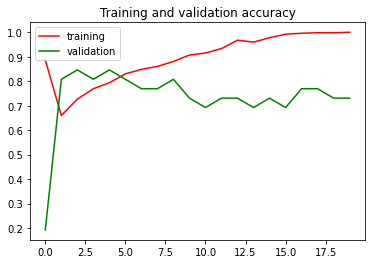

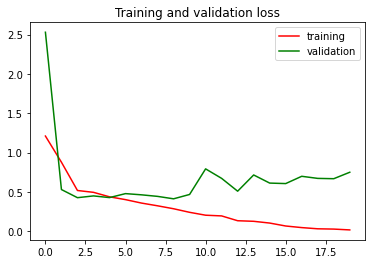

In [ ]:
#accuracy est un moyen de mesurer la fréquence à laquelle l'algorithme classe correctement un point de données.
# acc contient les valeurs des accuracy pour les données test  :
acc = train_model.history['acc']
# val_acc contient les valeurs des accuracy pour les données validation   :
val_acc = train_model.history['val_acc']

#loss_function : Cette fonction calculera essentiellement les performances de notre modèle en comparant ce que le modèle prédit avec la valeur réelle qu'il est censé produire.
# loss contient les valeurs du loss_function pour les données test  :
loss = train_model.history['loss']
# val_loss contient les valeurs du loss_function pour les données test  :
val_loss = train_model.history['val_loss']

#les nombre des epochs pour comparer les valeurs des accuracy ou les valeurs des loss function par rapport à leur évolution par rapport au nomre des epochs
epochs = range(len(acc))

# le première graph représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, acc,color='r',label = "training")
plt.plot(epochs, val_acc,color='g',label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()
#le deuxième graph représente les valeurs des accuracy pour les données test et validation par rapport au nombre des epochs 
plt.plot(epochs, loss,color='r', label = "training")
plt.plot(epochs, val_loss,color='g',label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')